# B2 김대호 종합실습 2

## 스케일 불량 원인 변수 분석

In [384]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import add_constant

from sklearn.svm import SVC 

# 모델 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# grhpviz
from sklearn.tree import export_graphviz
import graphviz

# 로지스틱 회귀
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score

# 의사결정나무
from sklearn.tree import DecisionTreeClassifier


# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

# 그레디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier

# 모델 성능 평가
from sklearn.metrics import confusion_matrix

# 압연 공정 데이터 파일 불러오기

In [385]:
df_raw = pd.read_csv("../../data/SCALE불량.csv", encoding="cp949")

In [386]:
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1125,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1120,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1106,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1113,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1118,873,적용,8,1조


In [387]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLATE_NO           720 non-null    object 
 1   ROLLING_DATE       720 non-null    object 
 2   SCALE              720 non-null    object 
 3   SPEC               720 non-null    object 
 4   STEEL_KIND         720 non-null    object 
 5   PT_THK             720 non-null    float64
 6   PT_WDTH            720 non-null    int64  
 7   PT_LTH             720 non-null    int64  
 8   PT_WGT             720 non-null    int64  
 9   FUR_NO             720 non-null    object 
 10  FUR_NO_ROW         720 non-null    int64  
 11  FUR_HZ_TEMP        720 non-null    int64  
 12  FUR_HZ_TIME        720 non-null    int64  
 13  FUR_SZ_TEMP        720 non-null    int64  
 14  FUR_SZ_TIME        720 non-null    int64  
 15  FUR_TIME           720 non-null    int64  
 16  FUR_EXTEMP         720 non

# 1. 데이터 분석 및 전처리

 * PLATE_NO, ROLLING_DATE(날짜) 컬럼 삭제
 * 철판번호와 날짜는 SCALE 오류에 영향을 끼치지 않는다고 생각하여 삭제한다.

In [388]:
df_raw.drop(['PLATE_NO', 'ROLLING_DATE'], axis = 1, inplace=True)
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1125,934,적용,8,2조
1,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1120,937,적용,8,2조
2,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1106,889,적용,8,3조
3,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1113,885,적용,8,3조
4,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1118,873,적용,8,1조


## 결측치 확인 및 처리

In [389]:
df_raw.isnull().sum()

SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

## => 결측치가 존재하지 않는다.

- STEEL_KIND 변수의 범주를 보았을 때, T와 C로 나뉘고 뒤에 숫자만 바뀐다는 것을 unique()함수를 통해 확인할 수 있었다.

- 분석을 용이하게 하기 위해서 STEEL_KIND 를 'T'와 'C' 두 범주로 나눠지도록 수정한다.

In [390]:
df_raw["STEEL_KIND"].unique()

array(['T1', 'T8', 'T0', 'T5', 'C0', 'C3', 'C1', 'T7', 'T3'], dtype=object)

In [391]:
df_raw["STEEL_KIND"] = df_raw["STEEL_KIND"].str[:1]
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,양품,AB/EH32-TM,T,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1125,934,적용,8,2조
1,양품,AB/EH32-TM,T,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1120,937,적용,8,2조
2,양품,NV-E36-TM,T,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1106,889,적용,8,3조
3,양품,NV-E36-TM,T,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1113,885,적용,8,3조
4,양품,BV-EH36-TM,T,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1118,873,적용,8,1조


## 이상치 확인 및 제거

<AxesSubplot:>

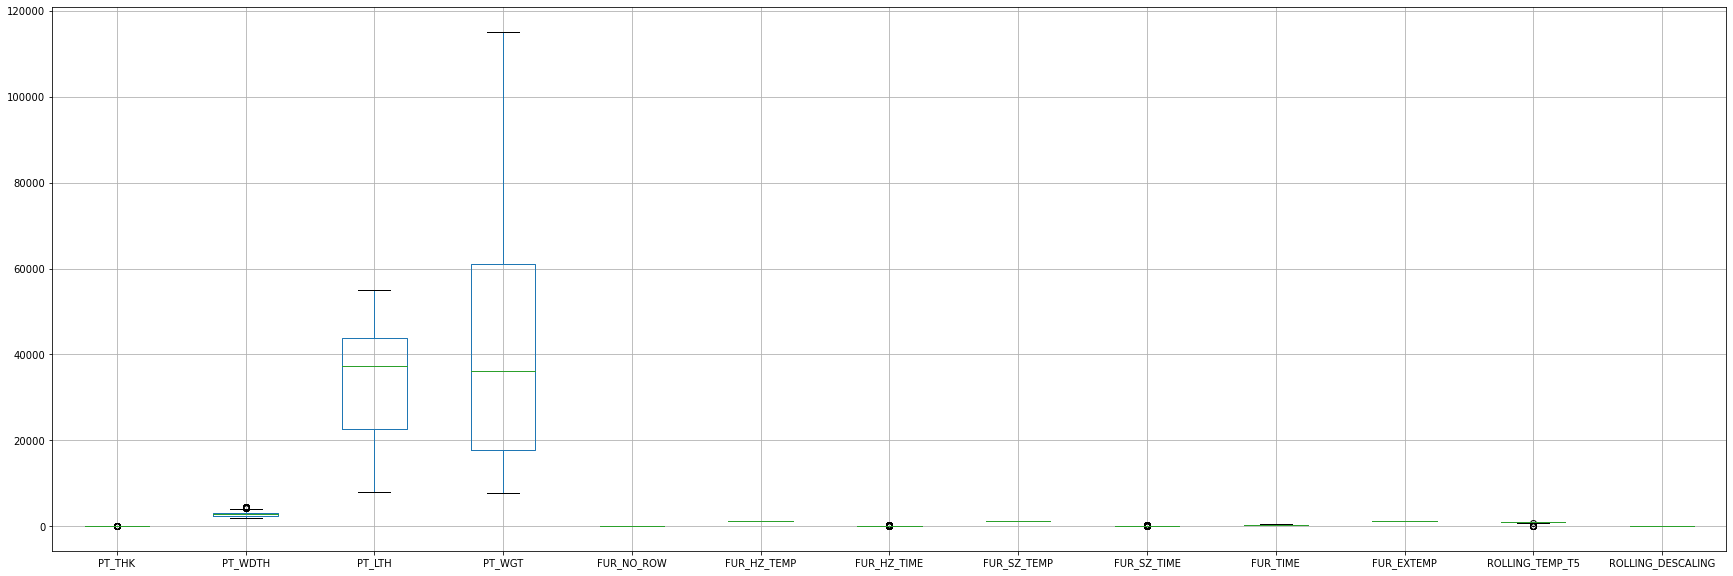

In [392]:
df_raw.boxplot(figsize = (30, 10))

## ROLLING_TEMP_T5 변수 값이 0이 나오는 이상치 발견

In [393]:
df_raw[df_raw["ROLLING_TEMP_T5"] == 0]

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
41,양품,GL-E36-TM,T,55.51,3765,11398,37400,3호기,2,1132,95,1128,80,341,1123,0,적용,6,1조
184,양품,JS-SM490YB,C,16.09,2221,43596,61150,3호기,1,1169,64,1164,61,308,1155,0,적용,10,3조
185,양품,JS-SM490YB,C,16.09,2221,43596,61150,3호기,2,1163,57,1166,67,303,1158,0,적용,10,4조
494,양품,PILAC-BT33,T,80.82,2085,12919,17090,2호기,1,1133,89,1122,59,378,1112,0,적용,6,2조
495,양품,PILAC-BT33,T,80.82,2085,13176,17430,1호기,2,1130,92,1124,61,362,1116,0,적용,6,3조
496,양품,NV-D32-TM,T,40.35,2497,23592,37320,3호기,1,1119,109,1117,76,383,1107,0,적용,6,3조


In [394]:
df_raw.drop(df_raw[df_raw["ROLLING_TEMP_T5"] == 0].index, inplace = True)
df_raw[df_raw["ROLLING_TEMP_T5"] == 0]

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR


In [395]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 719
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SCALE              714 non-null    object 
 1   SPEC               714 non-null    object 
 2   STEEL_KIND         714 non-null    object 
 3   PT_THK             714 non-null    float64
 4   PT_WDTH            714 non-null    int64  
 5   PT_LTH             714 non-null    int64  
 6   PT_WGT             714 non-null    int64  
 7   FUR_NO             714 non-null    object 
 8   FUR_NO_ROW         714 non-null    int64  
 9   FUR_HZ_TEMP        714 non-null    int64  
 10  FUR_HZ_TIME        714 non-null    int64  
 11  FUR_SZ_TEMP        714 non-null    int64  
 12  FUR_SZ_TIME        714 non-null    int64  
 13  FUR_TIME           714 non-null    int64  
 14  FUR_EXTEMP         714 non-null    int64  
 15  ROLLING_TEMP_T5    714 non-null    int64  
 16  HSB                714 non

### => 압연온도가 0인 경우는 발생할 수 있는 정상적인 케이스가 아니라고 생각하여 해당 데이터들을 삭제했다.

- FUR_NO 변수는 가열로 몇 호기에서 생산했는지를 알려준다.
- 그러나 가열로 자체가 원인이 되는 것은 다른 외부, 주변요인들의 영향이 클 수 있다고 생각했다.

- 만약 FUR_NO가 영향이 큰 설명변수라고 해도 생산량과 관련되어 있는 원인에 대한 개선 방향이나 해결책을 제시하기는 어렵다고 판단하여 FUR_NO 변수를 제거하기로 결정했다.

In [396]:
def fun_plot_hist(data, var):
    plt.hist(data[data["SCALE"] == "양품"][var], label = "양품", alpha = 0.5)
    plt.hist(data[data["SCALE"] == "불량"][var], label = "불량", alpha = 0.5)
    plt.title(var)
    plt.legend()

In [397]:
def fun_print_crosstab(data, var):
    return pd.crosstab(data["SCALE"], data[var], margins = True)

/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48520 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/b

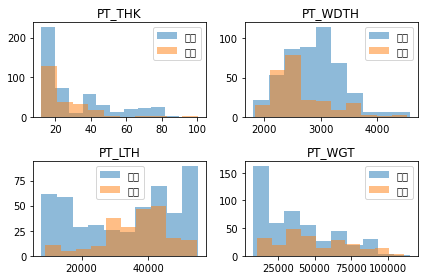

In [398]:
plt.subplot(2, 2, 1)
fun_plot_hist(df_raw, "PT_THK")
plt.subplot(2, 2, 2)
fun_plot_hist(df_raw, "PT_WDTH")
plt.subplot(2, 2, 3)
fun_plot_hist(df_raw, "PT_LTH")
plt.subplot(2, 2, 4)
fun_plot_hist(df_raw, "PT_WGT")

plt.tight_layout()

### Plate 두께

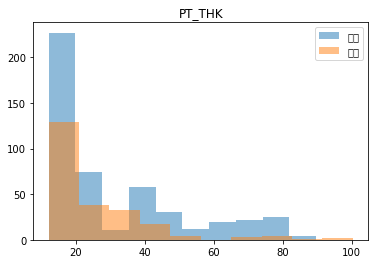

In [399]:
fun_plot_hist(df_raw, "PT_THK")

### Plate 폭

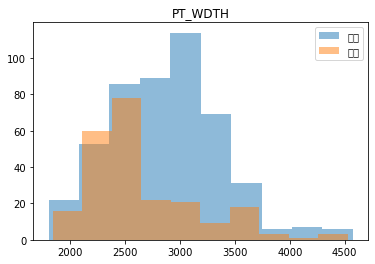

In [400]:
fun_plot_hist(df_raw, "PT_WDTH")

### Plate 길이

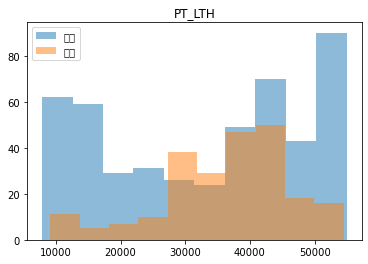

In [401]:
fun_plot_hist(df_raw, "PT_LTH")

### Plate 중량

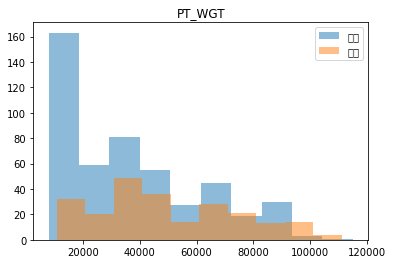

In [402]:
fun_plot_hist(df_raw, "PT_WGT")

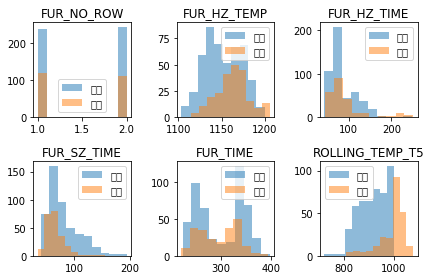

In [403]:
plt.subplot(2, 3, 1)
fun_plot_hist(df_raw, "FUR_NO_ROW")
plt.subplot(2, 3, 2)
fun_plot_hist(df_raw, "FUR_HZ_TEMP")
plt.subplot(2, 3, 3)
fun_plot_hist(df_raw, "FUR_HZ_TIME")
plt.subplot(2, 3, 4)
fun_plot_hist(df_raw, "FUR_SZ_TIME")
plt.subplot(2, 3, 5)
fun_plot_hist(df_raw, "FUR_TIME")
plt.subplot(2, 3, 6)
fun_plot_hist(df_raw, "ROLLING_TEMP_T5")

plt.tight_layout()

### 가열로 작업순번

In [404]:
fun_print_crosstab(df_raw, "FUR_NO_ROW")

FUR_NO_ROW,1,2,All
SCALE,,,
불량,120,111,231
양품,239,244,483
All,359,355,714


### 가열로 가열대 온도

/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48520 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/b

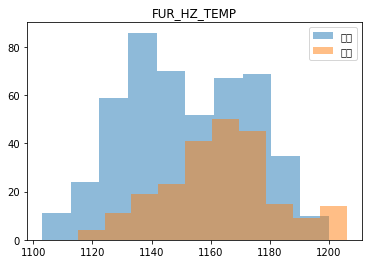

In [405]:
fun_plot_hist(df_raw, "FUR_HZ_TEMP")

### 가열로 가열대 시간

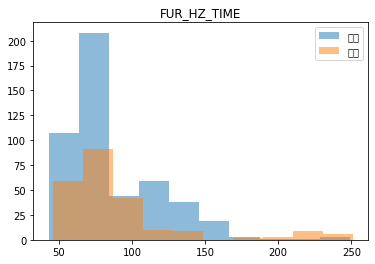

In [406]:
fun_plot_hist(df_raw, "FUR_HZ_TIME")

### 가열로 균열대 온도

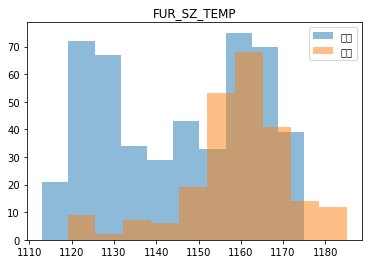

In [407]:
fun_plot_hist(df_raw, "FUR_SZ_TEMP")

### 가열로 균열대 시간

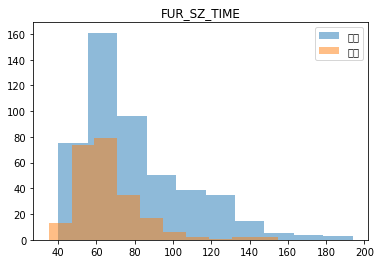

In [408]:
fun_plot_hist(df_raw, "FUR_SZ_TIME")

### 가열로 시간

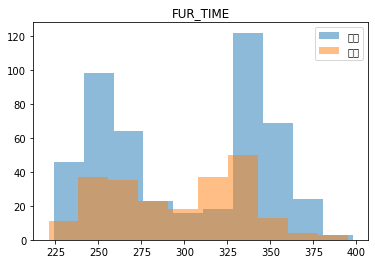

In [409]:
fun_plot_hist(df_raw, "FUR_TIME")

### 추출온도

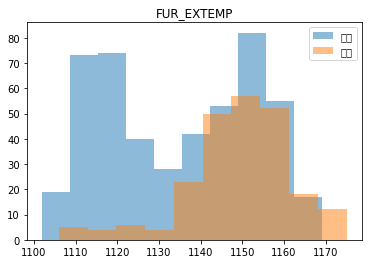

In [412]:
fun_plot_hist(df_raw, "FUR_EXTEMP")

### 압연온도

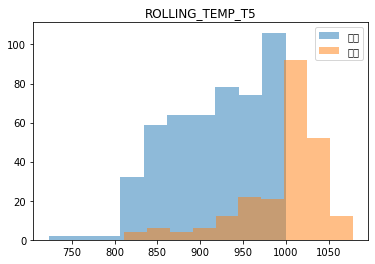

In [413]:
fun_plot_hist(df_raw, "ROLLING_TEMP_T5")

### 작업조

In [414]:
fun_print_crosstab(df_raw, "WORK_GR")

WORK_GR,1조,2조,3조,4조,All
SCALE,,,,,
불량,67,45,54,65,231
양품,121,119,115,128,483
All,188,164,169,193,714


### 가열로 작업순번

In [415]:
fun_print_crosstab(df_raw, "FUR_NO_ROW")

FUR_NO_ROW,1,2,All
SCALE,,,
불량,120,111,231
양품,239,244,483
All,359,355,714


### HSB 적용

In [416]:
fun_print_crosstab(df_raw, "HSB")

HSB,미적용,적용,All
SCALE,,,
불량,33,198,231
양품,0,483,483
All,33,681,714


### 제품 규격

In [417]:
fun_print_crosstab(df_raw, "SPEC")

SPEC,A131-DH36TM,A283-C,A516-60,A709-36,AB/A,AB/AH32,AB/B,AB/EH32-TM,AB/EH36-TM,API-2W-50T,...,NV-A36-TM,NV-B,NV-D32-TM,NV-D36-TM,NV-E32-TM,NV-E36-TM,PILAC-BT33,SA283-C,V42JBN3,All
SCALE,,,,,,,,,,,,,,,,,,,,,
불량,1,5,1,0,4,1,3,0,1,0,...,0,2,0,1,0,0,2,10,1,231
양품,0,1,1,1,3,4,3,2,16,2,...,2,1,3,4,2,5,36,11,3,483
All,1,6,2,1,7,5,6,2,17,2,...,2,3,3,5,2,5,38,21,4,714


### 강종

In [418]:
fun_print_crosstab(df_raw, "STEEL_KIND")

STEEL_KIND,C,T,All
SCALE,,,
불량,214,17,231
양품,295,188,483
All,509,205,714


## 모델 학습 전 목표변수 SCALE의 변화에 영향을 주지 않는 SPEC, FUR_NO, FUR_NO_ROW, WORK_GR 변수를 제거한다.

In [419]:
df_raw_final = df_raw.drop(["SPEC", "FUR_NO", "FUR_NO_ROW", "WORK_GR"], axis=1)

In [420]:
df_raw_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 719
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SCALE              714 non-null    object 
 1   STEEL_KIND         714 non-null    object 
 2   PT_THK             714 non-null    float64
 3   PT_WDTH            714 non-null    int64  
 4   PT_LTH             714 non-null    int64  
 5   PT_WGT             714 non-null    int64  
 6   FUR_HZ_TEMP        714 non-null    int64  
 7   FUR_HZ_TIME        714 non-null    int64  
 8   FUR_SZ_TEMP        714 non-null    int64  
 9   FUR_SZ_TIME        714 non-null    int64  
 10  FUR_TIME           714 non-null    int64  
 11  FUR_EXTEMP         714 non-null    int64  
 12  ROLLING_TEMP_T5    714 non-null    int64  
 13  HSB                714 non-null    object 
 14  ROLLING_DESCALING  714 non-null    int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 89.2+ KB


### HSB 변수는 "미적용"일 때 반드시 SCALE이 "불량"이다.
### 즉 HSB 변수에 따라 SCALE 이 바뀌는 것이 아닌
### HSB와 SCALE이 서로 큰 영향을 주지 않기 때문에 HSB 컬럼을 제거한다.

In [422]:
df_raw_final = df_raw_final.drop(df_raw[df_raw_final["HSB"]=="미적용"].index, inplace=False)

In [423]:
df_raw_final.drop("HSB", axis=1, inplace = True)

In [424]:
df_raw_final.columns

Index(['SCALE', 'STEEL_KIND', 'PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT',
       'FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME',
       'FUR_EXTEMP', 'ROLLING_TEMP_T5', 'ROLLING_DESCALING'],
      dtype='object')

### SCALE 변수를 양품일 때 0, 불량일 때 1로 바꾼다.

In [425]:
df_raw_final["SCALE"] = np.where(df_raw_final["SCALE"] == "불량", 1, 0)

In [426]:
df_raw_final.head()

,SCALE,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
0,0,T,32.25,3707,15109,14180,1144,116,1133,59,282,1125,934,8
1,0,T,32.25,3707,15109,14180,1144,122,1135,53,283,1120,937,8
2,0,T,33.27,3619,19181,18130,1129,116,1121,55,282,1106,889,8
3,0,T,33.27,3619,19181,18130,1152,125,1127,68,316,1113,885,8
4,0,T,38.33,3098,13334,12430,1140,134,1128,48,314,1118,873,8


In [428]:
df_train, df_test = train_test_split(df_raw_final,
                                     test_size =0.3, random_state=1234)

print("train data size: {}".format(df_train.shape))
print("Test data size: {}".format(df_test.shape))

train data size: (476, 14)
Test data size: (205, 14)


### SCALE 변수를 목표 변수로 하고 
### 나머지 변수들을 설명변수로 설정하여
### 로지스틱 회귀를 수행한다.

In [431]:
log_model = Logit.from_formula("""SCALE ~ + PT_THK 
+ PT_WDTH + PT_LTH + C(STEEL_KIND) + PT_WGT + PT_WGT
+ FUR_HZ_TIME + FUR_SZ_TEMP + FUR_TIME  
+ ROLLING_TEMP_T5 + ROLLING_DESCAILING""", df_train)
log_result = log_model.fit()

print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.282416
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  476
Model:                          Logit   Df Residuals:                      465
Method:                           MLE   Df Model:                           10
Date:                Wed, 26 May 2021   Pseudo R-squ.:                  0.5183
Time:                        01:22:06   Log-Likelihood:                -134.43
converged:                       True   LL-Null:                       -279.09
Covariance Type:            nonrobust   LLR p-value:                 2.802e-56
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -127.7341     24.887     -5.133      0.000    -176.511     -78.957
C(STE

### => Pseudo R-Squared : 0.52

### P-Value < 0.05 인 변수
- PT_WDTH, FUR_SZ_TEMP, ROLLING_TEMP_T5, ROLLING_DESCAILING

In [432]:
df_raw_final.drop("FUR_SZ_TEMP", axis=1, inplace = True)

In [433]:
df_raw_final.drop("FUR_EXTEMP", axis=1, inplace = True)

In [434]:
df_raw_final.columns

Index(['SCALE', 'STEEL_KIND', 'PT_THK', 'PT_WDTH', 'PT_LTH', 'PT_WGT',
       'FUR_HZ_TEMP', 'FUR_HZ_TIME', 'FUR_SZ_TIME', 'FUR_TIME',
       'ROLLING_TEMP_T5', 'ROLLING_DESCALING'],
      dtype='object')

In [435]:
y_pred = log_result.predict(df_test)

In [436]:
y_pred_class = (y_pred > 0.5).astype(int)

In [437]:
y_pred_class.count()

205

In [438]:
print(df_test["SCALE"].shape)
print("Accuracy:{0:.3f}\n".format(accuracy_score(df_test["SCALE"], y_pred_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["SCALE"], y_pred_class)))

(205,)
Accuracy:0.873

Confusion Matrix: 
[[126  11]
 [ 15  53]]


## SCALE 오류 예측 정확도 : 87.3%

## 정분류율 : 87.3%

In [439]:
df_char = df_raw_final.select_dtypes(include="object")
df_numeric = df_raw_final.select_dtypes(exclude="object")

# Data Scailing
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

# 문자데이터 + 숫자데이터
df_scaled = pd.concat([df_numeric_scaled, df_char], axis=1)
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,STEEL_KIND
0,-0.640264,0.172128,1.750079,-1.400609,-1.103183,-0.543827,0.768190,-0.624527,-0.403553,-0.125779,-0.19688,T
1,-0.640264,0.172128,1.750079,-1.400609,-1.103183,-0.543827,0.934547,-0.854151,-0.381367,-0.080379,-0.19688,T
2,-0.640264,0.226581,1.579297,-1.104231,-0.944443,-1.265656,0.768190,-0.777610,-0.403553,-0.806785,-0.19688,T
3,-0.640264,0.226581,1.579297,-1.104231,-0.944443,-0.158852,1.017725,-0.280090,0.350775,-0.867319,-0.19688,T
4,-0.640264,0.496711,0.568192,-1.529801,-1.173511,-0.736315,1.267261,-1.045505,0.306403,-1.048921,-0.19688,T


In [440]:
df_scaled["SCALE"] = df_raw_final["SCALE"]
df_scaled.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,STEEL_KIND
0,0.0,0.172128,1.750079,-1.400609,-1.103183,-0.543827,0.768190,-0.624527,-0.403553,-0.125779,-0.19688,T
1,0.0,0.172128,1.750079,-1.400609,-1.103183,-0.543827,0.934547,-0.854151,-0.381367,-0.080379,-0.19688,T
2,0.0,0.226581,1.579297,-1.104231,-0.944443,-1.265656,0.768190,-0.777610,-0.403553,-0.806785,-0.19688,T
3,0.0,0.226581,1.579297,-1.104231,-0.944443,-0.158852,1.017725,-0.280090,0.350775,-0.867319,-0.19688,T
4,0.0,0.496711,0.568192,-1.529801,-1.173511,-0.736315,1.267261,-1.045505,0.306403,-1.048921,-0.19688,T


In [441]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled,
                                     test_size =0.3, random_state=1234)
print("train data size: {}".format(df_scaled_train.shape))
print("Test data size: {}".format(df_scaled_test.shape))

train data size: (502, 12)
Test data size: (216, 12)


In [442]:
scaled_log_model = Logit.from_formula("""SCALE ~ + PT_THK 
    + PT_WDTH + PT_LTH + PT_WGT + FUR_HZ_TEMP 
    + FUR_HZ_TIME + FUR_TIME 
    + ROLLING_TEMP_T5 + ROLLING_DESCALING + C(STEEL_KIND)""", df_scaled_train)
scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.424895
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  SCALE   No. Observations:                  447
Model:                          Logit   Df Residuals:                      436
Method:                           MLE   Df Model:                           10
Date:                Wed, 26 May 2021   Pseudo R-squ.:                  0.3184
Time:                        01:22:08   Log-Likelihood:                -189.93
converged:                       True   LL-Null:                       -278.65
Covariance Type:            nonrobust   LLR p-value:                 7.938e-33
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.8897      0.284     -3.128      0.002      -1.447      -0.332
C(STE

## 로지스틱 회귀 분석 결과 : STEEL_KIND 변수의 영향력이 가장 크다는 것을 알 수 있다.

<AxesSubplot:>

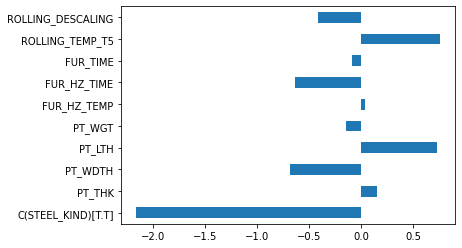

In [443]:
df_log_scaled_coef = pd.DataFrame({"Coef": scaled_log_result.params.values[1:]},
                                  index=scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef", legend= False)

In [444]:
df_raw_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 681 entries, 0 to 719
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SCALE              681 non-null    int64  
 1   STEEL_KIND         681 non-null    object 
 2   PT_THK             681 non-null    float64
 3   PT_WDTH            681 non-null    int64  
 4   PT_LTH             681 non-null    int64  
 5   PT_WGT             681 non-null    int64  
 6   FUR_HZ_TEMP        681 non-null    int64  
 7   FUR_HZ_TIME        681 non-null    int64  
 8   FUR_SZ_TIME        681 non-null    int64  
 9   FUR_TIME           681 non-null    int64  
 10  ROLLING_TEMP_T5    681 non-null    int64  
 11  ROLLING_DESCALING  681 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 89.2+ KB


In [445]:
df_raw_y = df_raw_final["SCALE"]
df_raw_x = df_raw_final.drop(["SCALE"], axis=1, inplace=False)
df_raw_x.shape

(681, 11)

In [446]:
df_raw_x_dummy = pd.get_dummies(df_raw_x)
df_raw_x_dummy.head()
df_raw_x_dummy.shape

(681, 12)

In [447]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x_dummy, df_raw_y, 
                                                                test_size=0.3, random_state=1234)
print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (476, 12)
train data Y size: (476,)
test data X size: (205, 12)
test data Y size: (205,)


In [448]:
tree_graph = DecisionTreeClassifier(random_state=1234)
dt_result = tree_graph.fit(df_train_x, df_train_y)

# Train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_graph.score(df_train_x, df_train_y)))
#test데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_graph.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


## 의사결정트리 분석 결과

In [449]:
tree_pred = tree_graph.predict(df_test_x)

print("Accuracy:{0:.3f}\n".format(tree_graph.score(df_test_x, df_test_y)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test_y, tree_pred)))

Accuracy:0.937

Confusion Matrix: 
[[128   9]
 [  4  64]]


## SCALE 변수 예측 정확도 : 93.7%
## 정분류울 : 93.7%

In [450]:
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"] = tree_graph.feature_importances_
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,ROLLING_TEMP_T5,0.708
0,PT_THK,0.088
4,FUR_HZ_TEMP,0.068
6,FUR_SZ_TIME,0.039
9,ROLLING_DESCALING,0.033
5,FUR_HZ_TIME,0.020
3,PT_WGT,0.020
7,FUR_TIME,0.012
1,PT_WDTH,0.012
2,PT_LTH,0.000


Text(0, 0.5, '변수')

/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib

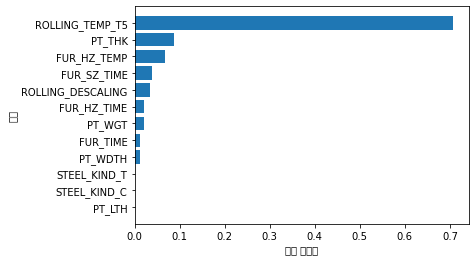

In [451]:
df_importance.sort_values("Importance", ascending= True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

## 가장 중요한 변수는 ROOLING_TEMP_T5라는 것을 알 수 있다.

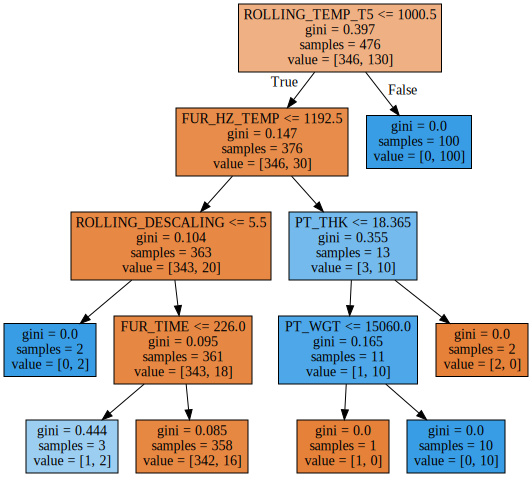

In [452]:
v_feature_name = df_train_x.columns

# 분리노드의 최소 자료수 설정
tree_graph = DecisionTreeClassifier(max_depth=4, random_state=1234)
tree_graph.fit(df_train_x, df_train_y)

## Tree 구조 생성 및 저장: 모델 시각화
export_graphviz(tree_graph, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 랜덤포레스트

In [453]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

rf_pred = rf_uncustomized.predict(df_test_x)

# Train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

#test데이터 정확도
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))
# confusion Matrix
print("Comfusion Matrix: \n{}".format(confusion_matrix(df_test_y, rf_pred)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937
Comfusion Matrix: 
[[136   1]
 [ 12  56]]


In [454]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"] = rf_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,ROLLING_TEMP_T5,0.459
9,ROLLING_DESCALING,0.093
1,PT_WDTH,0.071
0,PT_THK,0.070
4,FUR_HZ_TEMP,0.064
2,PT_LTH,0.047
11,STEEL_KIND_T,0.046
3,PT_WGT,0.033
7,FUR_TIME,0.033
6,FUR_SZ_TIME,0.029


## 랜덤포레스트에서 가장 중요한 변수는 ROLLING_TEMP_T5

Text(0, 0.5, '변수')

/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib

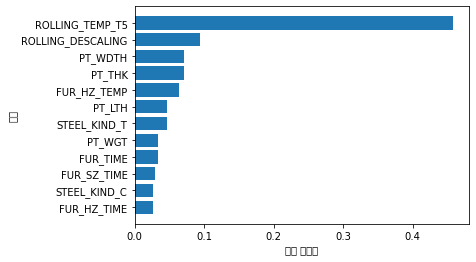

In [455]:
df_importance.sort_values("Importance", ascending= True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

# 그래디언트 부스팅

In [456]:
gb_uncustomized = GradientBoostingClassifier(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

gb_pred = rf_uncustomized.predict(df_test_x)

# Train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

#test데이터 정확
print("Accuracy on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

# confusion Matrix
print("Comfusion Matrix: \n{}".format(confusion_matrix(df_test_y, gb_pred)))

Accuracy on training set: 1.000
Accuracy on test set: 0.985
Comfusion Matrix: 
[[136   1]
 [ 12  56]]


In [457]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"] = gb_uncustomized.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,ROLLING_TEMP_T5,0.735
4,FUR_HZ_TEMP,0.082
0,PT_THK,0.061
9,ROLLING_DESCALING,0.053
1,PT_WDTH,0.019
7,FUR_TIME,0.019
3,PT_WGT,0.013
6,FUR_SZ_TIME,0.008
2,PT_LTH,0.007
5,FUR_HZ_TIME,0.003


## 랜덤포레스트 모델 결과에서 가장 중요한 변수는 ROLLING_TEMP_T5

Text(0, 0.5, '변수')

/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/Daeho/opt/anaconda3/lib/python3.8/site-packages/matplotlib

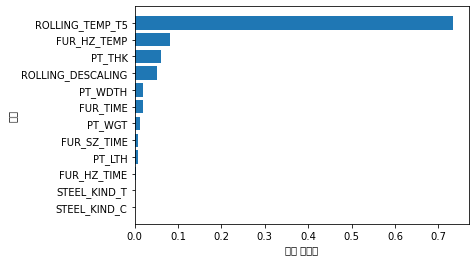

In [458]:
df_importance.sort_values("Importance", ascending= True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [459]:
# 로지스틱 회귀분석
print("Accuracy:{0:.3f}\n".format(accuracy_score(df_test["SCALE"], y_pred_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["SCALE"], y_pred_class)))

Accuracy:0.873

Confusion Matrix: 
[[126  11]
 [ 15  53]]


In [460]:
# 의사결정나무
print("Accuracy:{0:.3f}\n".format(tree_graph.score(df_test_x, df_test_y)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test_y, tree_pred)))

Accuracy:0.956

Confusion Matrix: 
[[128   9]
 [  4  64]]


In [461]:
# 랜덤포레스트
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))
print("Comfusion Matrix: \n{}".format(confusion_matrix(df_test_y, rf_pred)))

Accuracy on test set: 0.937
Comfusion Matrix: 
[[136   1]
 [ 12  56]]


In [462]:

# 그레디언트 부스팅
print("Accuracy on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))
print("Comfusion Matrix: \n{}".format(confusion_matrix(df_test_y, gb_pred)))

Accuracy on test set: 0.985
Comfusion Matrix: 
[[136   1]
 [ 12  56]]
